In [111]:
import matplotlib.pyplot as plt
from scipy.linalg import expm
import scipy.integrate as integrate
from sympy import Matrix
import numpy as np
import control 
import sympy
import os

In [112]:
A = [
    [13, -11, 14],
    [10, -7, 10],
    [-10, 6, -11]
]

B = [[-5, -3, 5]]
x1 = [[-3, -1, 1]]

In [113]:
A = np.array(A)
B = np.array(B).reshape(-1, 1)
x1 = np.array(x1).reshape(-1, 1)

In [114]:
def get_jordan_cells(A):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    
    n = A.shape[0]
    jordan_cells_poses = []
    jordan_cells = []
    current_jordan_cell_size = 1
    current_jordan_cell_pos = 0

    while current_jordan_cell_pos + current_jordan_cell_size < n:
        
        jordan_cell_down_element_pos = current_jordan_cell_pos + current_jordan_cell_size - 1
        if A[jordan_cell_down_element_pos, jordan_cell_down_element_pos + 1] == 1 or A[jordan_cell_down_element_pos + 1, jordan_cell_down_element_pos] == 1:
            current_jordan_cell_size += 1
        else:
            jordan_cells_poses.append((current_jordan_cell_pos, current_jordan_cell_size))
            current_jordan_cell_pos += current_jordan_cell_size
            current_jordan_cell_size = 1

    jordan_cells_poses.append((current_jordan_cell_pos, current_jordan_cell_size))
    
    for pos in jordan_cells_poses:
        jordan_cells.append(A[pos[0]:pos[0]+pos[1], pos[0]:pos[0]+pos[1]])

    return jordan_cells_poses, jordan_cells

In [115]:
J = np.array([
    [2, 1, 0, 0],
    [0, 2, 1, 0],
    [0, 0, 2, 1],
    [0, 0, 0, 2]
])
get_jordan_cells(J)

([(0, 4)],
 [array([[2, 1, 0, 0],
         [0, 2, 1, 0],
         [0, 0, 2, 1],
         [0, 0, 0, 2]])])

In [116]:
def get_control_matrix(A, B):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]

    n = A.shape[0]
    U = np.zeros((n, 0))
    for i in range(n):
        new_column = (np.linalg.matrix_power(A, i) @ B).reshape((-1, 1))
        U = np.concatenate((U, new_column), axis=1)

    return U
    

In [117]:
def check_eigenvalues_controllable(A, B, method = 'rank_criteria') -> np.array:
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]
    
    n = A.shape[0]
    is_controllable = []

    if method == 'rank_criteria':
        eigen_values, _ = np.linalg.eig(A)
        for eigen_value in eigen_values:
            M = np.concatenate((A - eigen_value * np.eye(n), B.reshape(-1, 1)), axis=1)
            is_controllable.append(np.linalg.matrix_rank(M) == n)
    elif method == 'jordan_form':
        P, J = Matrix(A).jordan_form()
        jordan_cells_poses, _ = get_jordan_cells(J)
        B_jordan_form = np.array(P.inv() @ B).T.flatten()

        for jordan_cells_pose in jordan_cells_poses:
            down_stroke_id = jordan_cells_pose[0] + jordan_cells_pose[1] - 1
            is_controllable.append(True if B_jordan_form[down_stroke_id] != 0 else False) 
    else:
        raise NotImplementedError

    return np.array(is_controllable)

In [118]:
def check_system_controllable(A, B, method = 'rank_criteria'):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == B.shape[0]
    
    is_controllable = None
    n = A.shape[0]
    if method == 'rank_criteria':
        U = get_control_matrix(A, B)
        is_controllable = np.linalg.matrix_rank(U) == n
    elif method == 'eigen_values_criteria':
        is_controllable = True
        _, J = Matrix(A).jordan_form()
        _, jordan_cells = get_jordan_cells(J)
       
        for i in range(len(jordan_cells)):
            for j in range(len(jordan_cells)):
                if i != j and np.array_equal(jordan_cells[i], jordan_cells[j]):
                    is_controllable = False
        
        is_controllable = is_controllable and np.all(check_eigenvalues_controllable(A, B))
    else:
        raise NotImplementedError
    
    return is_controllable

In [119]:
def check_is_state_controllable(A, B, x):
    U = get_control_matrix(A, B)
    return np.linalg.matrix_rank(U) == np.linalg.matrix_rank(np.concatenate((U, x.reshape(-1, 1)), axis=1))
    

In [120]:
def get_controllability_gramian(A, B, t1):
    controllability_gramian = integrate.quad_vec(lambda x: expm(A*x) @ B @ B.T @ expm(A.T*x), 0, t1)[0] 

    return controllability_gramian

In [121]:
def get_control(A, B, t1, x1, P = None):
    if P is None:
        P = get_controllability_gramian(A, B, t1)
    
    u = lambda t: (B.T @ expm(A.T*(t1 - t)) @ np.linalg.pinv(P) @  x1)[0][0]

    t = np.linspace(0, t1, 100)

    U = []
    for step in t:
        U.append(u(step))

    return U, t

Tests:

In [122]:
assert np.array_equal(get_control_matrix(A, B).shape, np.array((A.shape[0], A.shape[0]*B.shape[1])))
assert np.array_equal(check_eigenvalues_controllable(A, B, method = 'rank_criteria'), check_eigenvalues_controllable(A, B, method = 'jordan_form'))
assert check_system_controllable(A, B, method = 'rank_criteria') == check_system_controllable(A, B, method = 'eigen_values_criteria')
assert check_is_state_controllable(A, B, np.zeros(A.shape[0])) == True
A_test = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
])
B_test = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1],
])
P_test = np.array([
    [2./3., 1./3., 1./2., 1./2.],
    [1./3., 1./3., 0, 1./2.],
    [1./2., 0., 1., 0.],
    [1./2., 1./2., 0., 1.],
])
x1_test = np.array([[1, 1, 0, 0]]).reshape(-1, 1)
assert np.linalg.norm(get_controllability_gramian(A_test, B_test, t1=1) - P_test) < 0.001

In [123]:
def plot_result(A, B, U, t):
    ss = control.ss(A, B, A * 0, B * 0)
    output = control.forced_response(ss, X0=[0,0,0], U=U, T=t).states

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    for i in range(3):
        axs[i//2, i % 2].plot(t, output[i], linewidth=4)
        axs[i//2, i % 2].scatter(t[-1], x1[i], color='r', linewidth=4, label='goal')
        axs[i//2, i % 2].set_title(f'x_{i} = x_{i}(t)', fontsize=12)
        axs[i//2, i % 2].set_xlabel(f"t, [c]", fontsize=12)
        axs[i//2, i % 2].grid(True)
        axs[i//2, i % 2].legend()
        
        
    axs[1, 1].plot(t, np.array(U).reshape(-1), linewidth=4)
    axs[1, 1].set_title(f'u = u(t)', fontsize=12)
    axs[1, 1].set_xlabel(f"t, [c]", fontsize=12)
    axs[1, 1].grid(True)
    # plt.savefig(f'{file_name}.jpg') 

Lab:

In [124]:
get_control_matrix(A, B)

array([[ -5.,  38., -59.],
       [ -3.,  21.,   3.],
       [  5., -23.,  -1.]])

In [125]:
check_system_controllable(A, B)

True

In [126]:
check_eigenvalues_controllable(A, B)

array([ True,  True,  True])

In [127]:
check_eigenvalues_controllable(A, B, method = 'jordan_form')

array([ True,  True,  True])

In [128]:
check_is_state_controllable(A, B, x1)

True

In [129]:
expm(A*1) @ B @ B.reshape(1, -1) @ expm(A.T*1)

array([[ 2.65554766,  0.82212141, -2.02110313],
       [ 0.82212141,  0.2545176 , -0.62570602],
       [-2.02110313, -0.62570602,  1.53823558]])

In [130]:
P = get_controllability_gramian(A, B, t1=3)

In [131]:
P, np.linalg.eig(P)[0]

(array([[ 3.13226347,  1.70315356, -2.4629419 ],
        [ 1.70315356,  1.47412296, -1.12126199],
        [-2.4629419 , -1.12126199,  2.76344352]]),
 array([6.26534005, 0.23256956, 0.87192033]))

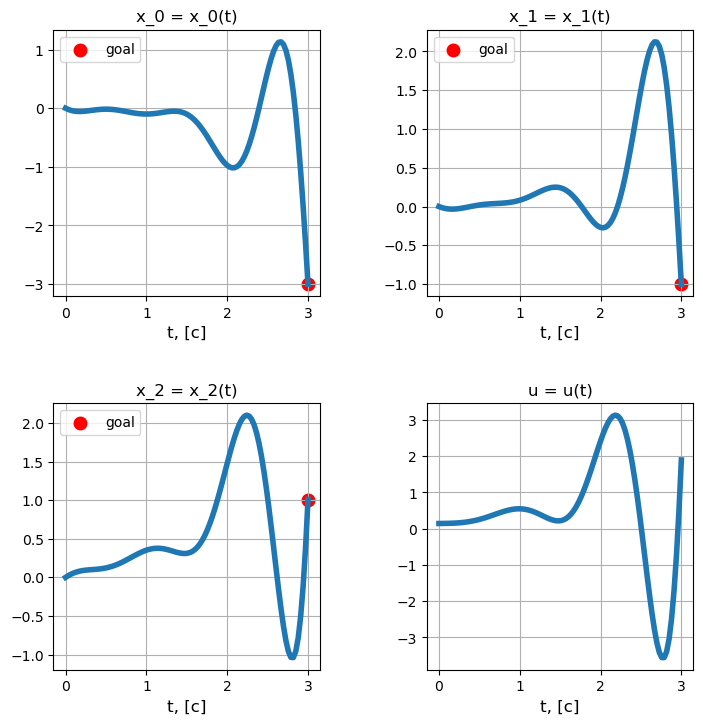

In [132]:
U, t = get_control(A, B, 3, x1)
plot_result(A, B, U, t)

# Задание №2

In [133]:
A = [
    [13, -11, 14],
    [10, -7, 10],
    [-10, 6, -11]
]

B = [[1, -1, 1]]
x1 = [[-3, -1, 1]]
x2 = [[-6, -1, 4]]

A = np.array(A)
B = np.array(B).reshape(-1, 1)
x1 = np.array(x1).reshape(-1, 1)
x2 = np.array(x2).reshape(-1, 1)

In [134]:
check_is_state_controllable(A, B, x1)

True

In [135]:
check_is_state_controllable(A, B, x2)

False

# Задание №3

In [136]:
A = np.array([
    [-13, 2, -12],
    [-6, -1, -8],
    [8, -4, 5]
])
C = np.array([[9, -2, 9]])

In [137]:
def get_observation_matrix(A, C):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]

    n = A.shape[0]
    U = np.zeros((0, n))
    for i in range(n):
        new_column = (C @ np.linalg.matrix_power(A, i))
        U = np.concatenate((U, new_column))

    return U
    

In [151]:
def check_eigenvalues_observable(A, C, method = 'rank_criteria') -> np.array:
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]
    
    n = A.shape[0]
    is_observable = None

    if method == 'rank_criteria':
        is_observable = []
        eigen_values, _ = np.linalg.eig(A)
        for eigen_value in eigen_values:
            M = np.concatenate((A - eigen_value * np.eye(n), C))
            is_observable.append(np.linalg.matrix_rank(M) == n)
    elif method == 'jordan_form':
        is_observable = []
        P, J = Matrix(A).jordan_form()
        jordan_cells_poses, _ = get_jordan_cells(J)
        C_jordan_form = C @ P
        for jordan_cells_pose in jordan_cells_poses:
            is_observable.append(True if C_jordan_form[jordan_cells_pose[0]] != 0 else False) 
    else:
        raise NotImplementedError

    return np.array(is_observable)

In [159]:
def check_system_observable(A, B, method = 'rank_criteria'):
    assert len(A.shape) == 2
    assert A.shape[0] == A.shape[1]
    assert A.shape[0] == C.shape[1]
    
    is_observable = None
    n = A.shape[0]
    if method == 'rank_criteria':
        U = get_control_matrix(A, B)
        is_observable = np.linalg.matrix_rank(U) == n
    elif method == 'eigen_values_criteria':
        is_observable = True
        _, J = Matrix(A).jordan_form()
        _, jordan_cells = get_jordan_cells(J)
       
        for i in range(len(jordan_cells)):
            for j in range(len(jordan_cells)):
                if i != j and np.array_equal(jordan_cells[i], jordan_cells[j]):
                    is_observable = False
        
        is_observable = is_observable and np.all(check_eigenvalues_observable(A, B))
    else:
        raise NotImplementedError
    
    return is_observable

In [163]:
def check_is_state_controllable(A, C, x):
    V = get_observation_matrix(A, C)
    print(V @ x)
    return np.array_equal(V @ x, np.zeros(5))
    

In [164]:
check_is_state_controllable(A, C, x1)

NameError: name 'x' is not defined

In [ ]:
def get_observability_gramian(A, C, t1):
    observability_gramian = integrate.quad_vec(lambda x: expm(A.T*x) @ C.T @ C @ expm(A*x), 0, t1)[0] 

    return observability_gramian

In [160]:
get_observation_matrix(A, C)

array([[  9.,  -2.,   9.],
       [-33., -16., -47.],
       [149., 138., 289.]])

In [161]:
check_eigenvalues_observable(A, C, method='jordan_form')

array([ True,  True,  True])

In [162]:
check_system_observable(A, C, method='eigen_values_criteria')

True